## Example notebook for predictive modeling pipeline

This notebook loads a dataset of titanic passenger information, cleans the data and runs simple feature engineering, and fits a logistic regression model to predict if a passenger survived the sinking. 

This code is not intended to showcase the best model for this purpose (the model does alright but other models can do better) or how to best construct a regression model. Instead, the aim here is to show how with relatively few modifications, we can turn `skeleton_fit_linear_model` into a functional pipeline.

Before running this code, you need to import the data. You can do this by running `load_data`.

In [16]:
#import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output

from scipy.stats import loguniform

from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

#import supporting functions used for cleaning
from supporting_functions import check_duplicates, one_hot, add_interactions, filter_features

In [17]:
#load data
if not os.path.exists("./data"):
    raise ValueError('You need to import the data first, run load_data.py')
else:
    #df = pd.read_csv('data/iris_data.csv',sep='\t')
    df = pd.read_csv('data/data_titanic.csv',sep='\t')

In [18]:
#user-defined target for classification
target_column = 'survived'

## Initial exploration

In [19]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [20]:
#report nans
df.isnull().mean()

survived       0.000000
pclass         0.000000
sex            0.000000
age            0.198653
sibsp          0.000000
parch          0.000000
fare           0.000000
embarked       0.002245
class          0.000000
who            0.000000
adult_male     0.000000
deck           0.772166
embark_town    0.002245
alive          0.000000
alone          0.000000
dtype: float64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [22]:
# Checking for data imbalance
df[target_column].value_counts()

survived
0    549
1    342
Name: count, dtype: int64

## Main function for cleaning

In [23]:
def clean_data(df,target_column):
    ### main preprocessing function:

    ## done on train and test set together
    
    #clean up column names
    df.columns = [col.replace(' ', '_') for col in df.columns]
    df.columns = [col.replace('(',  '') for col in df.columns]
    df.columns = [col.replace(')',  '') for col in df.columns]

    #drop column names that we don't need
    df = df.drop(['embark_town', 'alive', 'deck','who','class'],axis=1)

    #check and report on duplicate data
    df = check_duplicates(df)

    #run train-test split
    #note: X still contains the y-variable in the 'target' column, this is because it 
    #easier to remove rows / apply cleaning steps without having to do it separately 
    #for the target data vector.
    X = df
    X_train, X_test, _, _ = train_test_split(X, df[target_column], random_state=1234) 

    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)


    ## done separately for train and test

    #imputing
    X_train.age = X_train.age.fillna(X_train.age.median())
    X_test.age  = X_test.age.fillna(X_test.age.median())

    #non-linear scaling of values
    X_train['fare'] = X_train.fare.apply(lambda x: np.log(x) if x > 0 else 0)
    X_test['fare']  = X_test.fare.apply(lambda x: np.log(x) if x > 0 else 0)

    #define / identify columns for range normalization
    df['pclass'] = df['pclass'].astype('category')
    columns_to_scale = df.select_dtypes(include='number').columns.drop(target_column) #identify the numeric columns
  

    #remove outliers from the training set
    outlier_threshold = X_train['fare'].median()+(X_train['fare'].std()*3)
    print(str(np.sum(X_train['fare'] > outlier_threshold)) + " outliers detected")
    X_train = X_train[X_train['fare'] < outlier_threshold]
    X_train.reset_index(drop=True, inplace=True)    

    #range normalization
    scaler = MinMaxScaler()
    scaler.set_output(transform="pandas")

    X_train_scaled = scaler.fit_transform(X_train[columns_to_scale])
    X_test_scaled  = scaler.transform(X_test[columns_to_scale])
    X_train = pd.concat([X_train_scaled, X_train.drop(columns_to_scale,axis=1)], axis=1)
    X_test  = pd.concat([X_test_scaled, X_test.drop(columns_to_scale,axis=1)], axis=1)

    #separate the target
    y_train = X_train[target_column]
    X_train = X_train.drop(target_column,axis=1)
    y_test = X_test[target_column]
    X_test = X_test.drop(target_column,axis=1)

    return X_train, X_test, y_train, y_test

##  Main function for Feature engineering

In [24]:
def feature_engineer(df,columns_to_interact,columns_to_dummycode):
    ### main feature engineering function:

    #add interaction terms
    df = add_interactions(df,columns_to_interact)

    #one-hot encode categorical variables
    df = one_hot(df,columns_to_dummycode)

    return df

## Clean the data and make features

In [25]:
X_train, X_test, y_train, y_test = clean_data(df,target_column)

Data has 111 duplicates
2 outliers detected


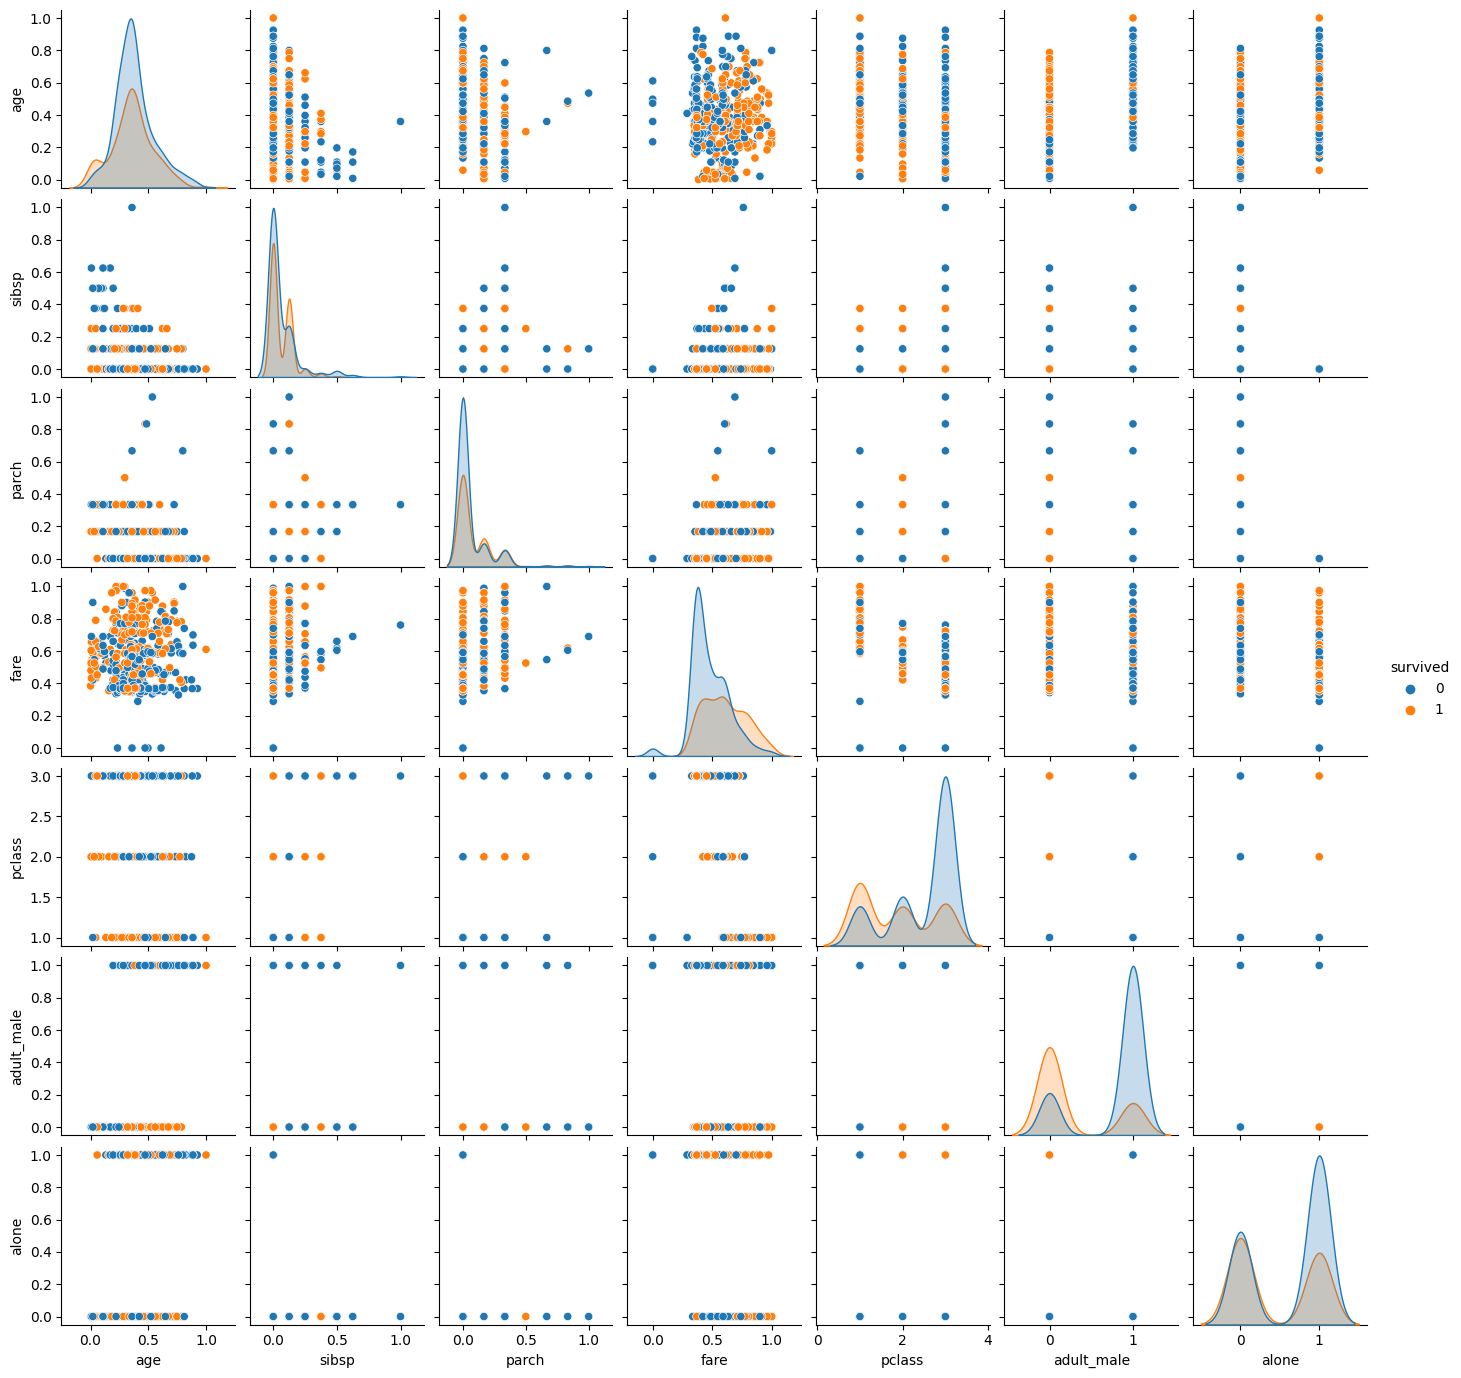

In [26]:
sns.pairplot(pd.concat([X_train, y_train],axis=1), hue="survived", height=2)

In [27]:
columns_to_interact  = ['adult_male','alone']
columns_to_dummycode = ['pclass','sex','embarked','adult_male','alone','adult_male alone']

X_train = feature_engineer(X_train,columns_to_interact,columns_to_dummycode)
X_test  = feature_engineer(X_test,columns_to_interact,columns_to_dummycode)

## Check the model and select features

In [28]:
#select features with filtering
thresh = 0.95 #remove features that correlate above this threshold
X_train, X_test = filter_features(X_train,X_test,thresh)

<Axes: >

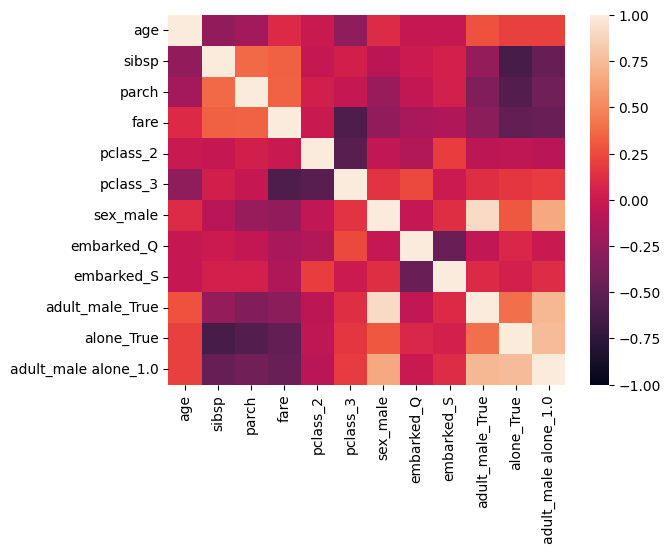

In [29]:
#plot correlation between regressors
sns.heatmap(X_train.corr(),vmin=-1,vmax=1)

## Fit the model

In [30]:
# instantiate logistic regression
lr = LogisticRegression(max_iter=10000)
#lr.get_params()
#lr.get_params().keys()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1234)

# define search space
param_grid = { "solver" : ['newton-cg', 'lbfgs', 'liblinear'],
               "penalty" : ['none', 'l1', 'l2', 'elasticnet'],
               "C" : loguniform(1e-5, 100)}

# define Random search
Random_search = RandomizedSearchCV(lr, param_grid, n_iter=500, scoring='accuracy', n_jobs=1, cv=cv, random_state=1)

# execute Random search
Random_search.fit(X_train, y_train)

#make predictions using the trained model
y_pred_train = Random_search.predict(X_train)
y_pred       = Random_search.predict(X_test)

clear_output(wait=False) #remove all the warnings, we don't need them here


## Evaluate the model

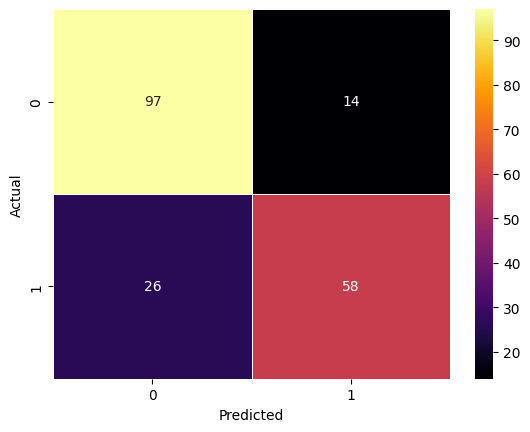

Training Set Performance:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       347
           1       0.78      0.72      0.75       236

    accuracy                           0.81       583
   macro avg       0.80      0.79      0.80       583
weighted avg       0.80      0.81      0.80       583


Testing Set Performance:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       111
           1       0.81      0.69      0.74        84

    accuracy                           0.79       195
   macro avg       0.80      0.78      0.79       195
weighted avg       0.80      0.79      0.79       195



In [31]:
cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, cmap='inferno', annot=True, fmt='d', linewidths=.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Training Set Performance:")
print(classification_report(y_train, y_pred_train))
print("\nTesting Set Performance:")
print(classification_report(y_test, y_pred))

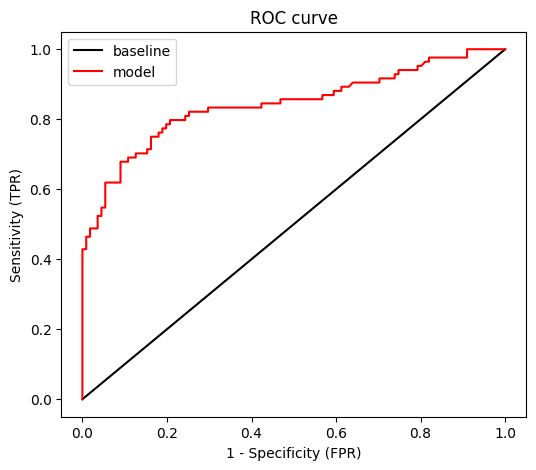

In [32]:
#calculate probabilities
y_prob_train = Random_search.predict_proba(X_train)
y_prob_test =  Random_search.predict_proba(X_test)

#calculate baseline and model ROC curves
base_fpr,  base_tpr,  _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, y_prob_test[:,1])
    
#plot ROC curves
plt.figure(figsize = (6, 5))
plt.plot(base_fpr, base_tpr, 'k', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('1 - Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.title('ROC curve')
plt.show()

In [33]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, y_prob_train[:,1])}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test,  y_prob_test[:,1])}')

Train ROC AUC Score: 0.8647242709910614
Test ROC AUC  Score: 0.8427713427713429
